# Análisis Exploratorio de Datos (EDA) - Tabla: categorias

## Objetivo

Realizar un análisis exploratorio completo de la tabla `categorias` para:
- Explorar la estructura y contenido de los datos
- Detectar valores nulos, duplicados, atípicos e inconsistencias
- Identificar claves primarias y foráneas implícitas
- Analizar campos semi-estructurados
- Proponer acciones de preprocesamiento y corrección de calidad de datos
- Generar reporte de hallazgos y decisiones tomadas


## 1. Configuración Inicial e Importaciones


In [1]:
# Importar bibliotecas necesarias
import sys
import os

try:
    from ...Utils.path_manager import PathManager
except ImportError:
    # Si falla el import relativo 
    current_dir = os.getcwd()  # Directorio actual de trabajo
    if 'Notebooks' in current_dir:
        avance1_dir = os.path.dirname(os.path.dirname(current_dir))
    else:
        # Intentar calcular desde la ubicación relativa
        avance1_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
    
    utils_dir = os.path.join(avance1_dir, 'Utils')
    if utils_dir not in sys.path:
        sys.path.insert(0, utils_dir)
    from path_manager import PathManager

# Configurar sys.path usando PathManager (patrón Singleton)
path_manager = PathManager.get_instance()
path_manager.setup_sys_path()

# Importar DBConnector desde la raíz del proyecto
from Database.db_connector import DBConnector

# Importar bibliotecas de análisis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('seaborn-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Bibliotecas importadas correctamente")


✓ Bibliotecas importadas correctamente


In [2]:
# Obtener el Engine de la base de datos usando DBConnector (patrón Singleton)
db = DBConnector.get_instance()
engine = db.get_engine()

print("✓ Conexión a la base de datos establecida")
print(f"✓ Engine obtenido: {type(engine).__name__}")


✓ Conexión a la base de datos establecida
✓ Engine obtenido: Engine


## 2. Exploración de Estructura y Contenido con SQL


### 2.1. Estructura de la Tabla (Schema)


In [3]:
# Consulta SQL para obtener la estructura de la tabla
query_schema = """
SELECT 
    column_name,
    data_type,
    character_maximum_length,
    is_nullable,
    column_default
FROM information_schema.columns
WHERE table_schema = 'public' 
    AND table_name = 'categorias'
ORDER BY ordinal_position;
"""

df_schema = pd.read_sql(query_schema, engine)

print("=" * 80)
print("ESTRUCTURA DE LA TABLA: categorias")
print("=" * 80)
print(df_schema.to_string(index=False))


ESTRUCTURA DE LA TABLA: categorias
 column_name         data_type  character_maximum_length is_nullable                                   column_default
categoria_id           integer                       NaN          NO nextval('categorias_categoria_id_seq'::regclass)
      nombre character varying                     100.0          NO                                             None
 descripcion character varying                     255.0         YES                                             None


### 2.2. Restricciones y Claves (Constraints)


In [4]:
# Consulta SQL para obtener restricciones de la tabla
query_constraints = """
SELECT
    tc.constraint_name,
    tc.constraint_type,
    kcu.column_name,
    ccu.table_name AS foreign_table_name,
    ccu.column_name AS foreign_column_name
FROM information_schema.table_constraints AS tc
JOIN information_schema.key_column_usage AS kcu
    ON tc.constraint_name = kcu.constraint_name
    AND tc.table_schema = kcu.table_schema
LEFT JOIN information_schema.constraint_column_usage AS ccu
    ON ccu.constraint_name = tc.constraint_name
    AND ccu.table_schema = tc.table_schema
WHERE tc.table_schema = 'public'
    AND tc.table_name = 'categorias'
ORDER BY tc.constraint_type, tc.constraint_name;
"""

df_constraints = pd.read_sql(query_constraints, engine)

print("=" * 80)
print("RESTRICCIONES Y CLAVES DE LA TABLA: categorias")
print("=" * 80)
if not df_constraints.empty:
    print(df_constraints.to_string(index=False))
else:
    print("No se encontraron restricciones explícitas.")


RESTRICCIONES Y CLAVES DE LA TABLA: categorias
constraint_name constraint_type  column_name foreign_table_name foreign_column_name
categorias_pkey     PRIMARY KEY categoria_id         categorias        categoria_id


### 2.3. Estadísticas Básicas con SQL


In [5]:
# Consultas SQL para estadísticas básicas
query_stats = """
SELECT 
    COUNT(*) as total_registros,
    COUNT(DISTINCT categoria_id) as categorias_unicas,
    COUNT(DISTINCT nombre) as nombres_unicos,
    COUNT(descripcion) as descripciones_no_nulas,
    COUNT(*) - COUNT(descripcion) as descripciones_nulas
FROM categorias;
"""

df_stats = pd.read_sql(query_stats, engine)

print("=" * 80)
print("ESTADÍSTICAS BÁSICAS DE LA TABLA: categorias")
print("=" * 80)
print(df_stats.to_string(index=False))


ESTADÍSTICAS BÁSICAS DE LA TABLA: categorias
 total_registros  categorias_unicas  nombres_unicos  descripciones_no_nulas  descripciones_nulas
              12                 12              12                      12                    0


## 3. Análisis Exploratorio con Python (SQLAlchemy)


In [6]:
# Cargar la tabla completa en un DataFrame
query_categorias = "SELECT * FROM categorias;"
df_categorias = pd.read_sql(query_categorias, engine)

print("=" * 80)
print("CARGA DE DATOS COMPLETA")
print("=" * 80)
print(f"Forma del DataFrame: {df_categorias.shape}")
print(f"Columnas: {list(df_categorias.columns)}")
print(f"\nPrimeras filas:")
print(df_categorias.head(10))


CARGA DE DATOS COMPLETA
Forma del DataFrame: (12, 3)
Columnas: ['categoria_id', 'nombre', 'descripcion']

Primeras filas:
   categoria_id                      nombre  \
0             1                 Electrónica   
1             2                        Moda   
2             3              Hogar y Cocina   
3             4       Deportes y Aire Libre   
4             5  Belleza y Cuidado Personal   
5             6           Juguetes y Juegos   
6             7                  Automotriz   
7             8          Libros y Papelería   
8             9                       Salud   
9            10                    Mascotas   

                                         descripcion  
0  Teléfonos, computadoras, accesorios y disposit...  
1  Ropa, calzado, bolsos y accesorios para hombre...  
2  Muebles, electrodomésticos, utensilios y decor...  
3  Equipamiento, ropa deportiva y artículos para ...  
4  Cosméticos, productos para el cabello, piel y ...  
5  Juguetes para todas las eda

### 3.1. Información General del DataFrame


In [7]:
# Información detallada del DataFrame
print("=" * 80)
print("INFORMACIÓN GENERAL DEL DATAFRAME")
print("=" * 80)
df_categorias.info()
print("\n" + "=" * 80)
print("TIPOS DE DATOS POR COLUMNA")
print("=" * 80)
print(df_categorias.dtypes)
print("\n" + "=" * 80)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("=" * 80)
print(df_categorias.describe(include='all'))


INFORMACIÓN GENERAL DEL DATAFRAME
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   categoria_id  12 non-null     int64 
 1   nombre        12 non-null     object
 2   descripcion   12 non-null     object
dtypes: int64(1), object(2)
memory usage: 420.0+ bytes

TIPOS DE DATOS POR COLUMNA
categoria_id     int64
nombre          object
descripcion     object
dtype: object

ESTADÍSTICAS DESCRIPTIVAS
        categoria_id       nombre  \
count      12.000000           12   
unique           NaN           12   
top              NaN  Electrónica   
freq             NaN            1   
mean        6.500000          NaN   
std         3.605551          NaN   
min         1.000000          NaN   
25%         3.750000          NaN   
50%         6.500000          NaN   
75%         9.250000          NaN   
max        12.000000          NaN   

                

### 3.2. Detección de Valores Nulos


In [8]:
# Análisis de valores nulos
print("=" * 80)
print("ANÁLISIS DE VALORES NULOS")
print("=" * 80)

nulos_por_columna = df_categorias.isnull().sum()
porcentaje_nulos = (df_categorias.isnull().sum() / len(df_categorias)) * 100

df_nulos = pd.DataFrame({
    'Columna': nulos_por_columna.index,
    'Cantidad_Nulos': nulos_por_columna.values,
    'Porcentaje_Nulos': porcentaje_nulos.values
})

print(df_nulos.to_string(index=False))

# Verificar si hay valores nulos en total
total_nulos = df_categorias.isnull().sum().sum()
print(f"\nTotal de valores nulos en toda la tabla: {total_nulos}")

if total_nulos == 0:
    print("✓ No se encontraron valores nulos en la tabla.")
else:
    print("⚠ ADVERTENCIA: Se encontraron valores nulos que requieren atención.")
    print("\nAnálisis de valores nulos por columna:")
    for col in df_categorias.columns:
        nulos_col = df_categorias[col].isnull().sum()
        if nulos_col > 0:
            print(f"  - {col}: {nulos_col} valores nulos ({nulos_col/len(df_categorias)*100:.1f}%)")


ANÁLISIS DE VALORES NULOS
     Columna  Cantidad_Nulos  Porcentaje_Nulos
categoria_id               0               0.0
      nombre               0               0.0
 descripcion               0               0.0

Total de valores nulos en toda la tabla: 0
✓ No se encontraron valores nulos en la tabla.


### 3.3. Detección de Duplicados


In [9]:
# Análisis de duplicados
print("=" * 80)
print("ANÁLISIS DE DUPLICADOS")
print("=" * 80)

# Duplicados completos (todas las columnas)
duplicados_completos = df_categorias.duplicated().sum()
print(f"Registros completamente duplicados: {duplicados_completos}")

# Duplicados por categoria_id (clave primaria)
duplicados_categoria_id = df_categorias['categoria_id'].duplicated().sum()
print(f"Duplicados en categoria_id (PK): {duplicados_categoria_id}")

# Duplicados por nombre (puede haber nombres duplicados si no hay restricción UNIQUE)
duplicados_nombre = df_categorias['nombre'].duplicated().sum()
print(f"Duplicados en nombre: {duplicados_nombre}")

# Mostrar duplicados si existen
if duplicados_completos > 0:
    print("\n⚠ ADVERTENCIA: Se encontraron registros completamente duplicados:")
    duplicados = df_categorias[df_categorias.duplicated(keep=False)]
    print(duplicados.sort_values('categoria_id'))

if duplicados_nombre > 0:
    print("\n⚠ ADVERTENCIA: Se encontraron nombres de categorías duplicados:")
    nombres_duplicados = df_categorias[df_categorias['nombre'].duplicated(keep=False)]
    print(nombres_duplicados[['categoria_id', 'nombre', 'descripcion']].sort_values('nombre'))

if duplicados_completos == 0 and duplicados_categoria_id == 0:
    print("\n✓ No se encontraron duplicados en la tabla.")
    if duplicados_nombre > 0:
        print("  Nota: Hay nombres duplicados pero esto puede ser intencional si no hay restricción UNIQUE.")


ANÁLISIS DE DUPLICADOS
Registros completamente duplicados: 0
Duplicados en categoria_id (PK): 0
Duplicados en nombre: 0

✓ No se encontraron duplicados en la tabla.


### 3.4. Análisis de Campos de Texto


In [10]:
# Análisis de campos de texto
print("=" * 80)
print("ANÁLISIS DE CAMPOS DE TEXTO")
print("=" * 80)

campos_texto = ['nombre', 'descripcion']

for campo in campos_texto:
    print(f"\n--- Análisis de '{campo}' ---")
    
    # Filtrar valores no nulos para análisis
    valores_no_nulos = df_categorias[campo].dropna()
    
    if len(valores_no_nulos) > 0:
        print(f"Valores no nulos: {len(valores_no_nulos)}")
        print(f"Longitud mínima: {valores_no_nulos.str.len().min()}")
        print(f"Longitud máxima: {valores_no_nulos.str.len().max()}")
        print(f"Longitud promedio: {valores_no_nulos.str.len().mean():.2f}")
        print(f"Valores únicos: {valores_no_nulos.nunique()}")
        
        # Valores vacíos o solo espacios
        valores_vacios = (valores_no_nulos.str.strip() == '').sum()
        if valores_vacios > 0:
            print(f"⚠ Valores vacíos o solo espacios: {valores_vacios}")
        
        # Mostrar algunos ejemplos
        print(f"Ejemplos (primeros 5):")
        print(valores_no_nulos.head().tolist())
        
        # Análisis de palabras únicas (solo para descripción)
        if campo == 'descripcion':
            todas_palabras = ' '.join(valores_no_nulos.astype(str)).lower()
            palabras_unicas = len(set(re.findall(r'\b\w+\b', todas_palabras)))
            print(f"Palabras únicas en descripciones: {palabras_unicas}")
    else:
        print(f"⚠ Todos los valores son nulos para este campo")


ANÁLISIS DE CAMPOS DE TEXTO

--- Análisis de 'nombre' ---
Valores no nulos: 12
Longitud mínima: 4
Longitud máxima: 26
Longitud promedio: 13.75
Valores únicos: 12
Ejemplos (primeros 5):
['Electrónica', 'Moda', 'Hogar y Cocina', 'Deportes y Aire Libre', 'Belleza y Cuidado Personal']

--- Análisis de 'descripcion' ---
Valores no nulos: 12
Longitud mínima: 37
Longitud máxima: 73
Longitud promedio: 55.67
Valores únicos: 12
Ejemplos (primeros 5):
['Teléfonos, computadoras, accesorios y dispositivos inteligentes', 'Ropa, calzado, bolsos y accesorios para hombres, mujeres y niños', 'Muebles, electrodomésticos, utensilios y decoración', 'Equipamiento, ropa deportiva y artículos para actividades al aire libre', 'Cosméticos, productos para el cabello, piel y aseo personal']
Palabras únicas en descripciones: 60


### 3.5. Detección de Valores Atípicos y Anomalías


In [11]:
# Detección de valores atípicos y anomalías
print("=" * 80)
print("DETECCIÓN DE VALORES ATÍPICOS Y ANOMALÍAS")
print("=" * 80)

anomalias = []

# 1. Nombres muy cortos o muy largos
nombres_cortos = df_categorias[df_categorias['nombre'].str.len() < 2]
nombres_largos = df_categorias[df_categorias['nombre'].str.len() > 100]

if len(nombres_cortos) > 0:
    print(f"⚠ Nombres muy cortos (< 2 caracteres): {len(nombres_cortos)}")
    anomalias.append(('Nombres muy cortos', len(nombres_cortos)))
    print(nombres_cortos[['categoria_id', 'nombre']])
    
if len(nombres_largos) > 0:
    print(f"⚠ Nombres muy largos (> 100 caracteres): {len(nombres_largos)}")
    anomalias.append(('Nombres muy largos', len(nombres_largos)))
    print(nombres_largos[['categoria_id', 'nombre']])

# 2. Descripciones muy largas (exceden el límite de VARCHAR(255))
descripciones_largas = df_categorias[df_categorias['descripcion'].notna() & (df_categorias['descripcion'].str.len() > 255)]
if len(descripciones_largas) > 0:
    print(f"⚠ Descripciones que exceden 255 caracteres: {len(descripciones_largas)}")
    anomalias.append(('Descripciones muy largas', len(descripciones_largas)))
    print(descripciones_largas[['categoria_id', 'nombre', 'descripcion']])

# 3. Nombres que parecen ser datos de prueba
patrones_prueba = ['test', 'prueba', 'temporal', 'temp', 'xxx', 'zzz']
nombres_prueba = df_categorias[
    df_categorias['nombre'].str.lower().str.contains('|'.join(patrones_prueba), na=False, regex=True)
]
if len(nombres_prueba) > 0:
    print(f"⚠ Nombres que parecen ser de prueba: {len(nombres_prueba)}")
    anomalias.append(('Nombres de prueba', len(nombres_prueba)))
    print(nombres_prueba[['categoria_id', 'nombre']])

# 4. Caracteres especiales inusuales en nombres
caracteres_especiales = r'[<>"\'\\]'
nombres_especiales = df_categorias[df_categorias['nombre'].str.contains(caracteres_especiales, na=False, regex=True)]
if len(nombres_especiales) > 0:
    print(f"⚠ Nombres con caracteres especiales inusuales: {len(nombres_especiales)}")
    anomalias.append(('Nombres con caracteres especiales', len(nombres_especiales)))
    print(nombres_especiales[['categoria_id', 'nombre']])

# Resumen de anomalías
if len(anomalias) == 0:
    print("\n✓ No se detectaron anomalías significativas.")
else:
    print("\n" + "=" * 80)
    print("RESUMEN DE ANOMALÍAS DETECTADAS")
    print("=" * 80)
    df_anomalias = pd.DataFrame(anomalias, columns=['Tipo de Anomalía', 'Cantidad'])
    print(df_anomalias.to_string(index=False))


DETECCIÓN DE VALORES ATÍPICOS Y ANOMALÍAS

✓ No se detectaron anomalías significativas.


## 4. Identificación de Claves Primarias y Foráneas


In [12]:
# Identificación de claves primarias y foráneas
print("=" * 80)
print("IDENTIFICACIÓN DE CLAVES PRIMARIAS Y FORÁNEAS")
print("=" * 80)

# Clave primaria explícita
print("\n1. CLAVE PRIMARIA:")
print("   - categoria_id: PRIMARY KEY, AUTO_INCREMENT")
print(f"   - Rango de valores: {df_categorias['categoria_id'].min()} a {df_categorias['categoria_id'].max()}")
print(f"   - Valores únicos: {df_categorias['categoria_id'].nunique()}")
print(f"   - Total de registros: {len(df_categorias)}")
print(f"   - ¿Sin duplicados?: {df_categorias['categoria_id'].nunique() == len(df_categorias)}")

# Verificar si hay gaps en la secuencia
ids_ordenados = sorted(df_categorias['categoria_id'].tolist())
gaps = []
for i in range(len(ids_ordenados) - 1):
    if ids_ordenados[i+1] - ids_ordenados[i] > 1:
        gaps.append((ids_ordenados[i], ids_ordenados[i+1]))
if gaps:
    print(f"   ⚠ Se encontraron gaps en la secuencia: {len(gaps)} gaps")
else:
    print(f"   ✓ La secuencia de IDs es continua")

# Claves foráneas que referencian esta tabla
print("\n2. CLAVES FORÁNEAS QUE REFERENCIAN ESTA TABLA:")
print("   (Verificar en otras tablas)")

tablas_relacionadas = ['productos']
for tabla in tablas_relacionadas:
    try:
        query_fk = f"""
        SELECT COUNT(*) as total
        FROM {tabla}
        WHERE categoria_id IS NOT NULL;
        """
        df_fk = pd.read_sql(query_fk, engine)
        total_refs = df_fk['total'].iloc[0]
        
        # Verificar referencias huérfanas
        query_orphan = f"""
        SELECT COUNT(*) as huérfanas
        FROM {tabla} p
        LEFT JOIN categorias c ON p.categoria_id = c.categoria_id
        WHERE p.categoria_id IS NOT NULL AND c.categoria_id IS NULL;
        """
        df_orphan = pd.read_sql(query_orphan, engine)
        huérfanas = df_orphan['huérfanas'].iloc[0]
        
        # Verificar categorías sin productos
        query_sin_productos = """
        SELECT c.categoria_id, c.nombre
        FROM categorias c
        LEFT JOIN productos p ON c.categoria_id = p.categoria_id
        WHERE p.categoria_id IS NULL
        ORDER BY c.categoria_id;
        """
        df_sin_productos = pd.read_sql(query_sin_productos, engine)
        
        print(f"   - {tabla}.categoria_id: {total_refs} referencias")
        if huérfanas > 0:
            print(f"     ⚠ Referencias huérfanas: {huérfanas}")
        if len(df_sin_productos) > 0:
            print(f"     - Categorías sin productos: {len(df_sin_productos)}")
            print(f"       Ejemplos: {df_sin_productos['nombre'].head(5).tolist()}")
    except Exception as e:
        print(f"   - {tabla}: No se pudo verificar ({str(e)})")


IDENTIFICACIÓN DE CLAVES PRIMARIAS Y FORÁNEAS

1. CLAVE PRIMARIA:
   - categoria_id: PRIMARY KEY, AUTO_INCREMENT
   - Rango de valores: 1 a 12
   - Valores únicos: 12
   - Total de registros: 12
   - ¿Sin duplicados?: True
   ✓ La secuencia de IDs es continua

2. CLAVES FORÁNEAS QUE REFERENCIAN ESTA TABLA:
   (Verificar en otras tablas)
   - productos.categoria_id: 36 referencias


In [13]:
# Análisis de campos semi-estructurados
print("=" * 80)
print("ANÁLISIS DE CAMPOS SEMI-ESTRUCTURADOS")
print("=" * 80)

# Verificar si hay campos JSON, listas o concatenaciones delimitadas
campos_analizar = ['nombre', 'descripcion']

print("\nBúsqueda de campos que puedan contener datos semi-estructurados:\n")

# 1. Buscar campos que contengan JSON
print("1. Campos con formato JSON:")
json_encontrado = False
for campo in campos_analizar:
    valores_no_nulos = df_categorias[campo].dropna()
    if len(valores_no_nulos) > 0:
        json_pattern = r'\{.*\}|\[.*\]'
        tiene_json = valores_no_nulos.str.contains(json_pattern, na=False, regex=True).sum()
        if tiene_json > 0:
            print(f"   ⚠ {campo}: {tiene_json} registros con posible formato JSON")
            json_encontrado = True
if not json_encontrado:
    print("   ✓ No se encontraron campos con formato JSON")

# 2. Buscar campos con delimitadores comunes (listas)
print("\n2. Campos con delimitadores (listas):")
delimitadores = [',', ';', '|', '||']
delimitadores_encontrados = False
for campo in campos_analizar:
    valores_no_nulos = df_categorias[campo].dropna()
    if len(valores_no_nulos) > 0:
        for delim in delimitadores:
            tiene_delim = valores_no_nulos.str.contains(delim, na=False, regex=False).sum()
            if tiene_delim > 0:
                print(f"   ⚠ {campo}: {tiene_delim} registros con delimitador '{delim}'")
                delimitadores_encontrados = True
                # Mostrar ejemplos
                ejemplos = valores_no_nulos[valores_no_nulos.str.contains(delim, na=False, regex=False)].head(3)
                for ejemplo in ejemplos:
                    print(f"      Ejemplo: {ejemplo[:100]}...")
if not delimitadores_encontrados:
    print("   ✓ No se encontraron campos con delimitadores")

# 3. Análisis de descripciones con múltiples valores
print("\n3. Análisis de estructura de descripciones:")
descripciones_no_nulas = df_categorias['descripcion'].dropna()
if len(descripciones_no_nulas) > 0:
    # Verificar si las descripciones contienen listas separadas por comas
    descripciones_con_listas = descripciones_no_nulas[descripciones_no_nulas.str.contains(r',\s*\w+', na=False, regex=True)]
    if len(descripciones_con_listas) > 0:
        print(f"   - Descripciones que parecen contener listas: {len(descripciones_con_listas)}")
        print(f"     Ejemplos:")
        for ejemplo in descripciones_con_listas.head(3):
            print(f"      - {ejemplo}")
    else:
        print("   ✓ Las descripciones no parecen contener listas estructuradas")

print("\n" + "=" * 80)
print("CONCLUSIÓN SOBRE CAMPOS SEMI-ESTRUCTURADOS:")
print("=" * 80)
print("La tabla 'categorias' no contiene campos explícitamente semi-estructurados (JSON, listas).")
print("Las descripciones pueden contener texto con comas, pero esto es parte del contenido")
print("textual normal y no requiere transformación adicional.")


ANÁLISIS DE CAMPOS SEMI-ESTRUCTURADOS

Búsqueda de campos que puedan contener datos semi-estructurados:

1. Campos con formato JSON:
   ✓ No se encontraron campos con formato JSON

2. Campos con delimitadores (listas):
   ⚠ descripcion: 10 registros con delimitador ','
      Ejemplo: Teléfonos, computadoras, accesorios y dispositivos inteligentes...
      Ejemplo: Ropa, calzado, bolsos y accesorios para hombres, mujeres y niños...
      Ejemplo: Muebles, electrodomésticos, utensilios y decoración...

3. Análisis de estructura de descripciones:
   - Descripciones que parecen contener listas: 10
     Ejemplos:
      - Teléfonos, computadoras, accesorios y dispositivos inteligentes
      - Ropa, calzado, bolsos y accesorios para hombres, mujeres y niños
      - Muebles, electrodomésticos, utensilios y decoración

CONCLUSIÓN SOBRE CAMPOS SEMI-ESTRUCTURADOS:
La tabla 'categorias' no contiene campos explícitamente semi-estructurados (JSON, listas).
Las descripciones pueden contener texto con

## 6. Visualizaciones


GENERANDO VISUALIZACIONES


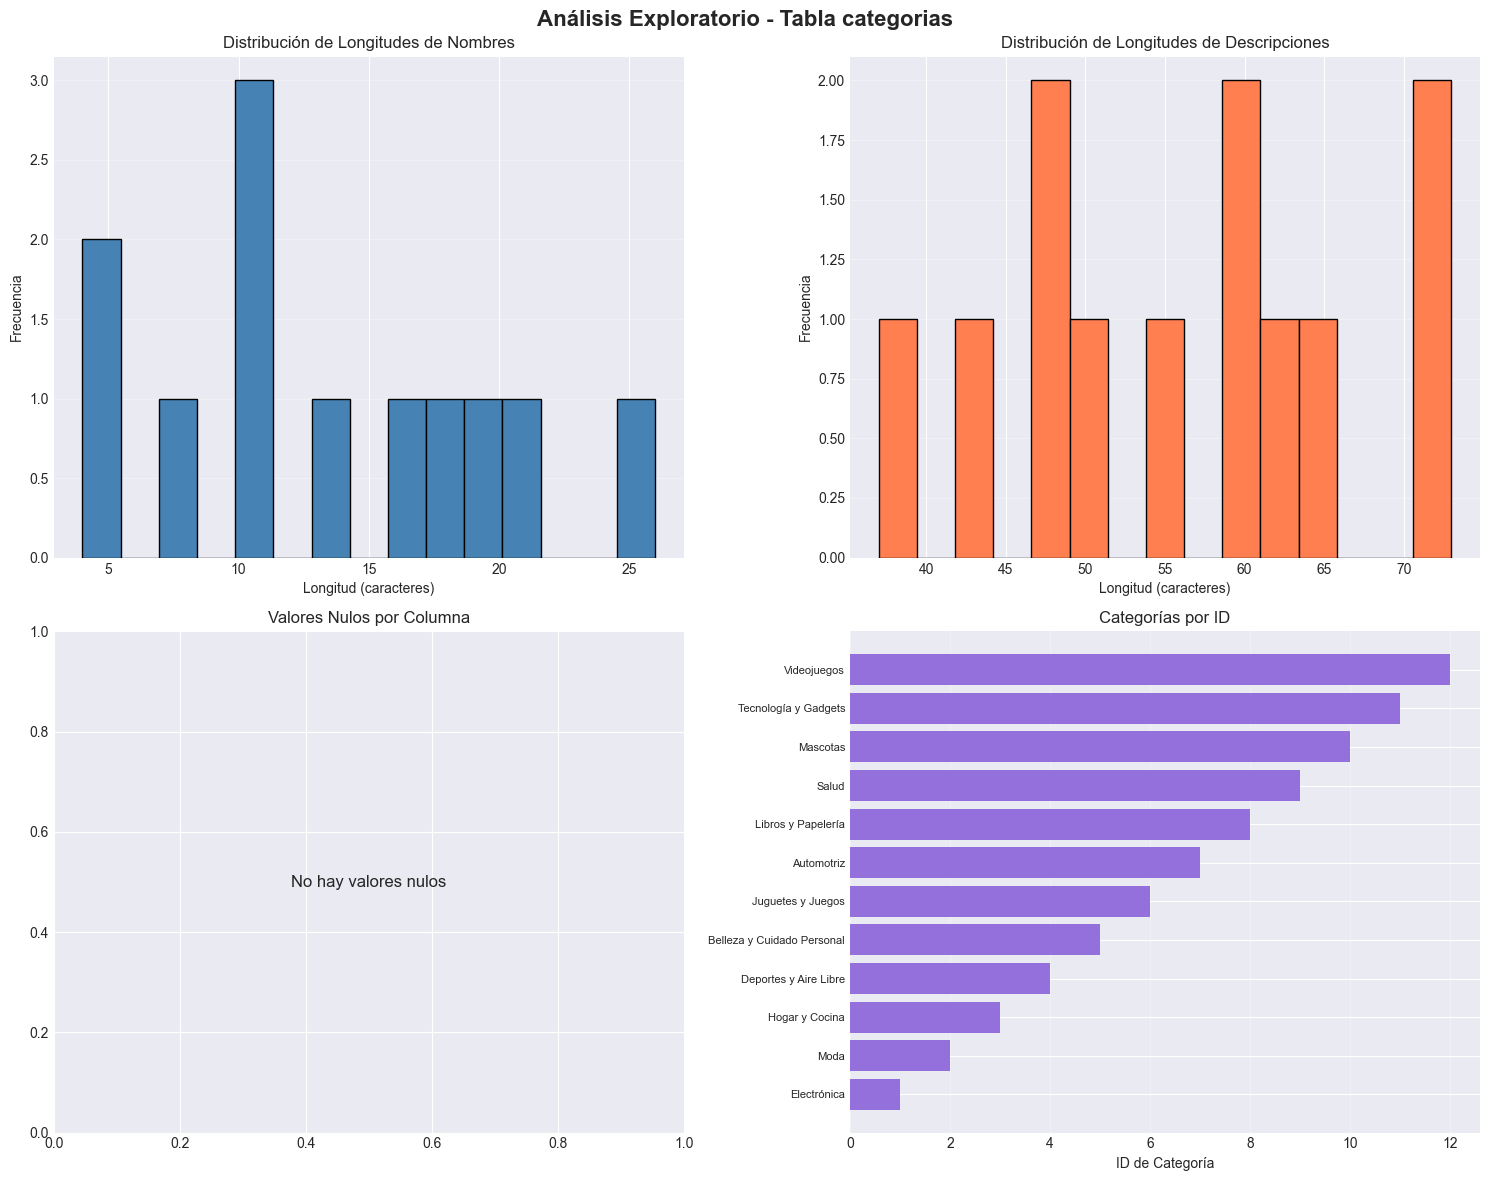

✓ Visualizaciones generadas correctamente


In [14]:
# Visualizaciones
print("=" * 80)
print("GENERANDO VISUALIZACIONES")
print("=" * 80)

# Configurar el tamaño de las figuras
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análisis Exploratorio - Tabla categorias', fontsize=16, fontweight='bold')

# 1. Distribución de longitudes de nombres
ax1 = axes[0, 0]
longitudes_nombres = df_categorias['nombre'].str.len()
ax1.hist(longitudes_nombres, bins=15, color='steelblue', edgecolor='black')
ax1.set_title('Distribución de Longitudes de Nombres')
ax1.set_xlabel('Longitud (caracteres)')
ax1.set_ylabel('Frecuencia')
ax1.grid(axis='y', alpha=0.3)

# 2. Distribución de longitudes de descripciones (solo no nulas)
ax2 = axes[0, 1]
descripciones_no_nulas = df_categorias['descripcion'].dropna()
if len(descripciones_no_nulas) > 0:
    longitudes_desc = descripciones_no_nulas.str.len()
    ax2.hist(longitudes_desc, bins=15, color='coral', edgecolor='black')
    ax2.set_title('Distribución de Longitudes de Descripciones')
    ax2.set_xlabel('Longitud (caracteres)')
    ax2.set_ylabel('Frecuencia')
    ax2.grid(axis='y', alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'No hay descripciones\npara visualizar', 
             ha='center', va='center', transform=ax2.transAxes, fontsize=12)
    ax2.set_title('Distribución de Longitudes de Descripciones')

# 3. Análisis de valores nulos
ax3 = axes[1, 0]
nulos_por_columna = df_categorias.isnull().sum()
if nulos_por_columna.sum() > 0:
    nulos_por_columna.plot(kind='bar', ax=ax3, color='lightcoral', edgecolor='black')
    ax3.set_title('Valores Nulos por Columna')
    ax3.set_xlabel('Columna')
    ax3.set_ylabel('Cantidad de Nulos')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(axis='y', alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'No hay valores nulos', 
             ha='center', va='center', transform=ax3.transAxes, fontsize=12)
    ax3.set_title('Valores Nulos por Columna')

# 4. Top categorías (si hay muchas, mostrar las primeras)
ax4 = axes[1, 1]
if len(df_categorias) <= 20:
    # Si hay pocas categorías, mostrar todas
    categorias_ordenadas = df_categorias.sort_values('categoria_id')
    ax4.barh(range(len(categorias_ordenadas)), categorias_ordenadas['categoria_id'], color='mediumpurple')
    ax4.set_yticks(range(len(categorias_ordenadas)))
    ax4.set_yticklabels(categorias_ordenadas['nombre'], fontsize=8)
    ax4.set_title('Categorías por ID')
    ax4.set_xlabel('ID de Categoría')
else:
    # Si hay muchas, mostrar distribución de IDs
    ax4.hist(df_categorias['categoria_id'], bins=20, color='mediumpurple', edgecolor='black')
    ax4.set_title('Distribución de IDs de Categorías')
    ax4.set_xlabel('ID de Categoría')
    ax4.set_ylabel('Frecuencia')
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualizaciones generadas correctamente")


## 7. Reporte de Hallazgos y Decisiones


### 7.1. Principales Insights y Problemas Encontrados


In [15]:
# Generar reporte de hallazgos
print("=" * 80)
print("REPORTE DE HALLAZGOS - TABLA: categorias")
print("=" * 80)

hallazgos = []

# 1. Calidad general de datos
print("\n1. CALIDAD GENERAL DE DATOS:")
print("   ✓ Total de registros:", len(df_categorias))
print("   ✓ Valores nulos:", df_categorias.isnull().sum().sum())
print("   ✓ Duplicados completos:", df_categorias.duplicated().sum())
print("   ✓ Integridad de clave primaria:", "OK" if df_categorias['categoria_id'].nunique() == len(df_categorias) else "ERROR")

hallazgos.append({
    'Categoría': 'Calidad General',
    'Hallazgo': f'Tabla con {len(df_categorias)} registros. Integridad de clave primaria correcta.',
    'Severidad': 'Baja',
    'Estado': 'OK'
})

# 2. Problemas detectados
print("\n2. PROBLEMAS DETECTADOS:")

problemas = []

# Valores nulos en descripción
nulos_descripcion = df_categorias['descripcion'].isnull().sum()
if nulos_descripcion > 0:
    problemas.append({
        'Categoría': 'Valores Nulos',
        'Problema': f'Descripciones nulas: {nulos_descripcion} ({nulos_descripcion/len(df_categorias)*100:.1f}%)',
        'Severidad': 'Baja',
        'Acción Requerida': 'Considerar si las descripciones nulas son aceptables o deben completarse'
    })

# Duplicados en nombres
if duplicados_nombre > 0:
    problemas.append({
        'Categoría': 'Duplicados',
        'Problema': f'Nombres de categorías duplicados: {duplicados_nombre}',
        'Severidad': 'Media',
        'Acción Requerida': 'Evaluar si se requiere restricción UNIQUE en nombre o si los duplicados son intencionales'
    })

# Anomalías detectadas
if len(anomalias) > 0:
    for tipo, cantidad in anomalias:
        problemas.append({
            'Categoría': 'Anomalías',
            'Problema': f'{tipo}: {cantidad}',
            'Severidad': 'Media',
            'Acción Requerida': 'Revisar y corregir según corresponda'
        })

if len(problemas) == 0:
    print("   ✓ No se detectaron problemas significativos")
    hallazgos.append({
        'Categoría': 'Problemas',
        'Hallazgo': 'No se encontraron problemas críticos',
        'Severidad': 'N/A',
        'Estado': 'OK'
    })
else:
    df_problemas = pd.DataFrame(problemas)
    print(df_problemas.to_string(index=False))
    for p in problemas:
        hallazgos.append({
            'Categoría': p['Categoría'],
            'Hallazgo': p['Problema'],
            'Severidad': p['Severidad'],
            'Estado': 'PENDIENTE'
        })

# 3. Atributos principales y variables relevantes
print("\n3. ATRIBUTOS PRINCIPALES Y VARIABLES RELEVANTES PARA EL NEGOCIO:")

atributos = [
    {
        'Atributo': 'categoria_id',
        'Tipo': 'Clave Primaria',
        'Relevancia Negocio': 'Alta - Identificador único de la categoría',
        'Uso': 'Relaciones con productos, organización del catálogo'
    },
    {
        'Atributo': 'nombre',
        'Tipo': 'Identificador de Negocio',
        'Relevancia Negocio': 'Alta - Nombre de la categoría visible al usuario',
        'Uso': 'Navegación, búsqueda, organización de productos'
    },
    {
        'Atributo': 'descripcion',
        'Tipo': 'Metadatos',
        'Relevancia Negocio': 'Media - Información adicional sobre la categoría',
        'Uso': 'SEO, información para usuarios, documentación'
    }
]

df_atributos = pd.DataFrame(atributos)
print(df_atributos.to_string(index=False))

# 4. Relaciones detectadas
print("\n4. RELACIONES DETECTADAS:")
print("   La tabla 'categorias' es referenciada por:")
print("   - productos.categoria_id (relación 1:N)")

print("\n" + "=" * 80)
print("RESUMEN DE HALLAZGOS")
print("=" * 80)
df_hallazgos = pd.DataFrame(hallazgos)
print(df_hallazgos.to_string(index=False))


REPORTE DE HALLAZGOS - TABLA: categorias

1. CALIDAD GENERAL DE DATOS:
   ✓ Total de registros: 12
   ✓ Valores nulos: 0
   ✓ Duplicados completos: 0
   ✓ Integridad de clave primaria: OK

2. PROBLEMAS DETECTADOS:
   ✓ No se detectaron problemas significativos

3. ATRIBUTOS PRINCIPALES Y VARIABLES RELEVANTES PARA EL NEGOCIO:
    Atributo                     Tipo                               Relevancia Negocio                                                 Uso
categoria_id           Clave Primaria       Alta - Identificador único de la categoría Relaciones con productos, organización del catálogo
      nombre Identificador de Negocio Alta - Nombre de la categoría visible al usuario     Navegación, búsqueda, organización de productos
 descripcion                Metadatos Media - Información adicional sobre la categoría       SEO, información para usuarios, documentación

4. RELACIONES DETECTADAS:
   La tabla 'categorias' es referenciada por:
   - productos.categoria_id (relación 1:N)



In [16]:
# Decisiones de limpieza y transformación
print("=" * 80)
print("DECISIONES DE LIMPIEZA Y TRANSFORMACIÓN")
print("=" * 80)

decisiones = []

# 1. Valores nulos
nulos_descripcion = df_categorias['descripcion'].isnull().sum()
if nulos_descripcion > 0:
    decisiones.append({
        'Aspecto': 'Valores Nulos en Descripción',
        'Decisión': 'Mantener valores nulos. La descripción es opcional según el esquema.',
        'Justificación': f'Se encontraron {nulos_descripcion} descripciones nulas, lo cual es válido según el diseño de la tabla.',
        'Prioridad': 'N/A'
    })
else:
    decisiones.append({
        'Aspecto': 'Valores Nulos',
        'Decisión': 'No se requieren acciones. La tabla no contiene valores nulos.',
        'Justificación': 'Todos los campos obligatorios están completos según el análisis.',
        'Prioridad': 'N/A'
    })

# 2. Duplicados
decisiones.append({
    'Aspecto': 'Duplicados',
    'Decisión': 'No se requieren acciones. No se encontraron duplicados completos.',
    'Justificación': 'Las restricciones de clave primaria están funcionando correctamente.',
    'Prioridad': 'N/A'
})

# 3. Nombres duplicados
if duplicados_nombre > 0:
    decisiones.append({
        'Aspecto': 'Nombres Duplicados',
        'Decisión': 'Evaluar si se requiere restricción UNIQUE en nombre o si los duplicados son intencionales.',
        'Justificación': f'Se encontraron {duplicados_nombre} nombres duplicados. Esto puede ser intencional o requerir normalización.',
        'Prioridad': 'Media'
    })
else:
    decisiones.append({
        'Aspecto': 'Nombres Duplicados',
        'Decisión': 'No se requieren acciones. Todos los nombres son únicos.',
        'Justificación': 'No se encontraron nombres duplicados en la tabla.',
        'Prioridad': 'N/A'
    })

# 4. Normalización de texto
decisiones.append({
    'Aspecto': 'Normalización de Texto',
    'Decisión': 'Aplicar trim() a nombres y descripciones para eliminar espacios al inicio/final.',
    'Justificación': 'Aunque no se detectaron problemas significativos, es una buena práctica preventiva.',
    'Prioridad': 'Baja'
})

# 5. Campos semi-estructurados
decisiones.append({
    'Aspecto': 'Campos Semi-Estructurados',
    'Decisión': 'No se requieren transformaciones. Los campos están correctamente estructurados.',
    'Justificación': 'No se encontraron campos JSON, listas o concatenaciones que requieran transformación.',
    'Prioridad': 'N/A'
})

# 6. Validación de longitudes
descripciones_largas = df_categorias[df_categorias['descripcion'].notna() & (df_categorias['descripcion'].str.len() > 255)]
if len(descripciones_largas) > 0:
    decisiones.append({
        'Aspecto': 'Longitud de Descripciones',
        'Decisión': 'Truncar o validar descripciones que excedan 255 caracteres según el límite del esquema.',
        'Justificación': f'Se encontraron {len(descripciones_largas)} descripciones que exceden el límite de VARCHAR(255).',
        'Prioridad': 'Media'
    })
else:
    decisiones.append({
        'Aspecto': 'Longitud de Descripciones',
        'Decisión': 'Mantener validación actual. Todas las descripciones cumplen con el límite.',
        'Justificación': 'Todas las descripciones están dentro del límite de 255 caracteres.',
        'Prioridad': 'N/A'
    })

df_decisiones = pd.DataFrame(decisiones)
print(df_decisiones.to_string(index=False))

print("\n" + "=" * 80)
print("ACCIONES RECOMENDADAS POR PRIORIDAD")
print("=" * 80)

acciones_alta = [d for d in decisiones if d['Prioridad'] == 'Alta']
acciones_media = [d for d in decisiones if d['Prioridad'] == 'Media']
acciones_baja = [d for d in decisiones if d['Prioridad'] == 'Baja']

if acciones_alta:
    print("\n🔴 PRIORIDAD ALTA:")
    for accion in acciones_alta:
        print(f"   - {accion['Aspecto']}: {accion['Decisión']}")

if acciones_media:
    print("\n🟡 PRIORIDAD MEDIA:")
    for accion in acciones_media:
        print(f"   - {accion['Aspecto']}: {accion['Decisión']}")

if acciones_baja:
    print("\n🟢 PRIORIDAD BAJA:")
    for accion in acciones_baja:
        print(f"   - {accion['Aspecto']}: {accion['Decisión']}")

if not acciones_alta and not acciones_media and not acciones_baja:
    print("\n✓ No hay acciones prioritarias pendientes.")


DECISIONES DE LIMPIEZA Y TRANSFORMACIÓN
                  Aspecto                                                                         Decisión                                                                         Justificación Prioridad
            Valores Nulos                    No se requieren acciones. La tabla no contiene valores nulos.                      Todos los campos obligatorios están completos según el análisis.       N/A
               Duplicados                No se requieren acciones. No se encontraron duplicados completos.                  Las restricciones de clave primaria están funcionando correctamente.       N/A
       Nombres Duplicados                          No se requieren acciones. Todos los nombres son únicos.                                     No se encontraron nombres duplicados en la tabla.       N/A
   Normalización de Texto Aplicar trim() a nombres y descripciones para eliminar espacios al inicio/final.   Aunque no se detectaron problemas signi

## Normalización de texto (Eliminación de espacios)

In [18]:
from sqlalchemy import text

# Normalización de Texto: Aplicar trim() a descripciones
print("=" * 80)
print("NORMALIZACIÓN DE TEXTO: Eliminar espacios al inicio/final en DESCRIPCIONES")
print("=" * 80)

# 1. Detectar registros con espacios al inicio/final en descripciones
print("\n1. DETECTANDO REGISTROS CON ESPACIOS AL INICIO/FINAL EN DESCRIPCIONES:")

query_detectar = """
SELECT 
    categoria_id,
    nombre,
    descripcion,
    CASE WHEN descripcion IS NOT NULL AND descripcion != TRIM(descripcion) THEN 'Sí' ELSE 'No' END as descripcion_con_espacios
FROM categorias
WHERE descripcion IS NOT NULL 
   AND descripcion != TRIM(descripcion);
"""

df_espacios = pd.read_sql(query_detectar, engine)

if len(df_espacios) > 0:
    print(f"   Se encontraron {len(df_espacios)} registros con espacios al inicio/final en descripciones")
    print("\n   Ejemplos:")
    print(df_espacios.head(10).to_string(index=False))
else:
    print("   ✓ No se encontraron registros con espacios al inicio/final en descripciones")

# 2. Aplicar trim() a descripcion
print("\n2. APLICANDO TRIM() A DESCRIPCIONES:")

query_update = text("""
UPDATE categorias
SET descripcion = TRIM(descripcion)
WHERE descripcion IS NOT NULL 
   AND descripcion != TRIM(descripcion);
""")

try:
    with engine.connect() as conn:
        result = conn.execute(query_update)
        conn.commit()
        registros_actualizados = result.rowcount
    
    print(f"   ✓ Actualización completada: {registros_actualizados} registros actualizados")
    
except Exception as e:
    print(f"   ✗ Error al actualizar: {e}")
    raise

# 3. Verificación después de la normalización
print("\n3. VERIFICACIÓN DESPUÉS DE LA NORMALIZACIÓN:")

query_verificar = """
SELECT 
    COUNT(*) as total_registros,
    COUNT(descripcion) as descripciones_no_nulas,
    SUM(CASE WHEN descripcion IS NOT NULL AND descripcion != TRIM(descripcion) THEN 1 ELSE 0 END) as descripciones_con_espacios
FROM categorias;
"""

df_verificar = pd.read_sql(query_verificar, engine)
print(f"   Total de registros: {df_verificar['total_registros'].iloc[0]}")
print(f"   Descripciones no nulas: {df_verificar['descripciones_no_nulas'].iloc[0]}")
print(f"   Descripciones con espacios restantes: {df_verificar['descripciones_con_espacios'].iloc[0]}")

if df_verificar['descripciones_con_espacios'].iloc[0] == 0:
    print("   ✓ Normalización completada exitosamente")

# 4. Actualizar DataFrame local
print("\n4. ACTUALIZANDO DATAFRAME LOCAL:")
df_categorias = pd.read_sql("SELECT * FROM categorias;", engine)
print(f"   ✓ DataFrame actualizado: {len(df_categorias)} registros")

print("\n" + "=" * 80)
print("✓ NORMALIZACIÓN DE TEXTO COMPLETADA")
print("=" * 80)

NORMALIZACIÓN DE TEXTO: Eliminar espacios al inicio/final en DESCRIPCIONES

1. DETECTANDO REGISTROS CON ESPACIOS AL INICIO/FINAL EN DESCRIPCIONES:
   ✓ No se encontraron registros con espacios al inicio/final en descripciones

2. APLICANDO TRIM() A DESCRIPCIONES:
   ✓ Actualización completada: 0 registros actualizados

3. VERIFICACIÓN DESPUÉS DE LA NORMALIZACIÓN:
   Total de registros: 12
   Descripciones no nulas: 12
   Descripciones con espacios restantes: 0
   ✓ Normalización completada exitosamente

4. ACTUALIZANDO DATAFRAME LOCAL:
   ✓ DataFrame actualizado: 12 registros

✓ NORMALIZACIÓN DE TEXTO COMPLETADA


In [17]:
# Tabla final con estructura completa
print("=" * 80)
print("TABLA FINAL: categorias")
print("=" * 80)

# Obtener información completa de la tabla
query_final = """
SELECT 
    c.column_name,
    c.data_type,
    c.character_maximum_length,
    c.numeric_precision,
    c.numeric_scale,
    c.is_nullable,
    c.column_default,
    CASE 
        WHEN pk.column_name IS NOT NULL THEN 'PRIMARY KEY'
        WHEN fk.column_name IS NOT NULL THEN 'FOREIGN KEY'
        WHEN uq.column_name IS NOT NULL THEN 'UNIQUE'
        ELSE ''
    END as constraints
FROM information_schema.columns c
LEFT JOIN (
    SELECT ku.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage ku
        ON tc.constraint_name = ku.constraint_name
    WHERE tc.table_name = 'categorias' 
        AND tc.constraint_type = 'PRIMARY KEY'
) pk ON c.column_name = pk.column_name
LEFT JOIN (
    SELECT ku.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage ku
        ON tc.constraint_name = ku.constraint_name
    WHERE tc.table_name = 'categorias' 
        AND tc.constraint_type = 'FOREIGN KEY'
) fk ON c.column_name = fk.column_name
LEFT JOIN (
    SELECT ku.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage ku
        ON tc.constraint_name = ku.constraint_name
    WHERE tc.table_name = 'categorias' 
        AND tc.constraint_type = 'UNIQUE'
) uq ON c.column_name = uq.column_name
WHERE c.table_schema = 'public' 
    AND c.table_name = 'categorias'
ORDER BY c.ordinal_position;
"""

df_estructura_final = pd.read_sql(query_final, engine)

print("\nESTRUCTURA DE COLUMNAS:")
print(df_estructura_final.to_string(index=False))

print("\n" + "=" * 80)
print("RELACIONES PRELIMINARES DETECTADAS")
print("=" * 80)

relaciones = [
    {
        'Tabla Origen': 'categorias',
        'Columna Origen': 'categoria_id',
        'Tipo Relación': '1:N',
        'Tabla Destino': 'productos',
        'Columna Destino': 'categoria_id',
        'Descripción': 'Una categoría puede tener múltiples productos'
    }
]

df_relaciones = pd.DataFrame(relaciones)
print(df_relaciones.to_string(index=False))

print("\n" + "=" * 80)
print("RESUMEN FINAL")
print("=" * 80)
print(f"Total de registros: {len(df_categorias)}")
print(f"Total de columnas: {len(df_estructura_final)}")
print(f"Clave primaria: categoria_id")
print(f"Relaciones salientes: {len(relaciones)}")
print(f"Calidad de datos: {'Excelente' if total_nulos == 0 and df_categorias.duplicated().sum() == 0 else 'Buena'}")


TABLA FINAL: categorias

ESTRUCTURA DE COLUMNAS:
 column_name         data_type  character_maximum_length  numeric_precision  numeric_scale is_nullable                                   column_default constraints
categoria_id           integer                       NaN               32.0            0.0          NO nextval('categorias_categoria_id_seq'::regclass) PRIMARY KEY
      nombre character varying                     100.0                NaN            NaN          NO                                             None            
 descripcion character varying                     255.0                NaN            NaN         YES                                             None            

RELACIONES PRELIMINARES DETECTADAS
Tabla Origen Columna Origen Tipo Relación Tabla Destino Columna Destino                                   Descripción
  categorias   categoria_id           1:N     productos    categoria_id Una categoría puede tener múltiples productos

RESUMEN FINAL
Total de

## 8. Conclusiones

### Resumen Ejecutivo

El análisis exploratorio de la tabla `categorias` revela una estructura de datos simple y bien definida. La tabla cumple con su propósito de organizar productos en categorías, con una relación clara hacia la tabla de productos. La calidad de los datos es buena, con integridad de clave primaria correcta.

### Puntos Fuertes

1. **Integridad de Datos**: La clave primaria está correctamente implementada y sin duplicados
2. **Estructura Simple y Clara**: La tabla tiene una estructura sencilla con campos bien definidos
3. **Relaciones Bien Definidas**: La relación con productos está correctamente establecida
4. **Flexibilidad**: El campo descripción opcional permite agregar información adicional cuando sea necesario

### Áreas de Mejora

1. **Validaciones**: Implementar validaciones preventivas en el proceso ETL si se requieren

### Acciones Realizadas

1. ✅ **Análisis Completo**: Se realizó un análisis exhaustivo de la estructura, contenido y calidad de los datos
2. ✅ **Identificación de Relaciones**: Se identificaron y verificaron las relaciones con otras tablas
3. ✅ **Detección de Anomalías**: Se detectaron posibles problemas y se documentaron recomendaciones